In [1]:
#importing the dependencies
from sklearn import datasets
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import ensemble
import time
import numpy as np
from sklearn.svm import SVC
import pandas as pd
from collections import Counter
import imblearn
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB,MultinomialNB,_BaseNB

In [2]:
#faster training
from sklearnex import patch_sklearn
patch_sklearn()
#10 to 100x fast

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [3]:
#Load the data
lfw=datasets.fetch_lfw_people(min_faces_per_person=100,resize=0.5)

In [4]:
lfw.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [5]:
lfw.data.shape

(1140, 2914)

In [6]:
lfw.images.shape
imtotal,imx,imy=lfw.images.shape
print(imtotal,imx,imy)

1140 62 47


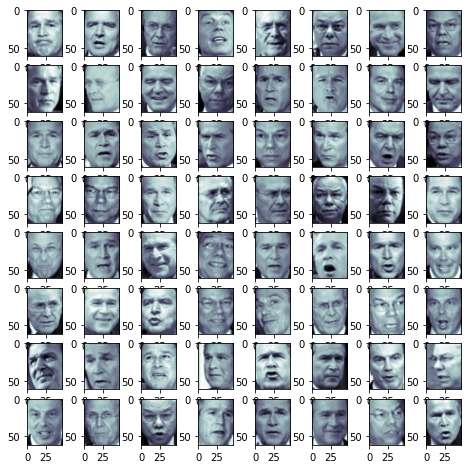

In [7]:
#plot the figures
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    ax.imshow(lfw.images[i],cmap=plt.cm.bone) 

In [8]:
x,y=lfw.data,lfw.target


In [9]:
print(imblearn.__version__)

0.7.0


In [10]:
# oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority",)
# x_u,y_u=oversample.fit_resample(x,y)
# Counter(y_u),Counter(y)

# oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority",)
# x_train,y_train=oversample.fit_resample(x_train,y_train)

In [11]:
#split the data for training and testing
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=0)

In [12]:
x_train.shape,x_test.shape,x.shape

((855, 2914), (285, 2914), (1140, 2914))

In [13]:
#PCA instance for checking how many features to take 
pca_check=PCA()
pca_check.fit(x_train)

PCA()

In [14]:
#check upto how many features a defined explained variance is reached
k=0
currsum=0
while currsum<0.90:  #for 90%
    currsum+=pca_check.explained_variance_ratio_[k]
    k+=1
k

78

In [15]:
pca_lwf=PCA(n_components=k,whiten=True)
#whiten does normalization (removes the relative variance scales of the components)
#Accuracy Score : 91.22% -> 91.57% by using whiten=True (SVC with PCA score)

In [16]:
x_train.shape

(855, 2914)

In [17]:
# len(x_train)

In [18]:
# clf=ensemble.RandomForestClassifier()
# grid={"max_leaf_nodes":list(np.arange(10,300))}
# gscv=GridSearchCV(clf,grid)
# gscv.fit(x_train,y_train)
# gscv.best_estimator_

In [19]:
# gscv.best_score_

In [20]:
# gscv.cv_results_

In [21]:
# clf=SVC()
# grid={"gamma":[.01,.1,1,10,100],"C":[.01,.1,1,10,100]}
# gscv=GridSearchCV(clf,grid)
# gscv.fit(x_train,y_train)
# gscv.best_estimator_

In [22]:
# gscv.best_score_

In [23]:
# gscv.cv_results_

In [24]:
#oversampling the train data for every non majority class
oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority")
x_train,y_train=oversample.fit_resample(x_train,y_train)

In [25]:
#Apply PCA on oversampled data
x_transformed=pca_lwf.fit_transform(x_train)

In [26]:
pca_lwf.n_components

78

In [27]:
x_transformed.shape

(2040, 78)

### Visualize approx data of faces ( generated by PCA tranform )

In [28]:
x_approx=pca_lwf.inverse_transform(x_transformed)
x_approx=x_approx.reshape((len(x_train),imx,imy))

In [29]:
x_approx.shape

(2040, 62, 47)

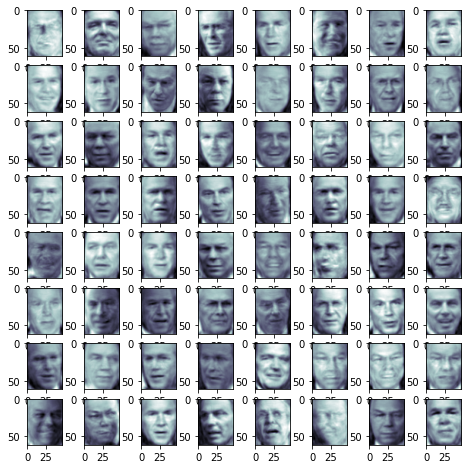

In [30]:
#Plot approx faces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(x_approx[i],cmap=plt.cm.bone)
plt.show()

### Visualize Eigenfaces/Eigenvectors

In [31]:
eigen=pca_lwf.components_
eigen_faces=eigen.reshape((eigen.shape[0],imx,imy))

In [32]:
eigen.shape

(78, 2914)

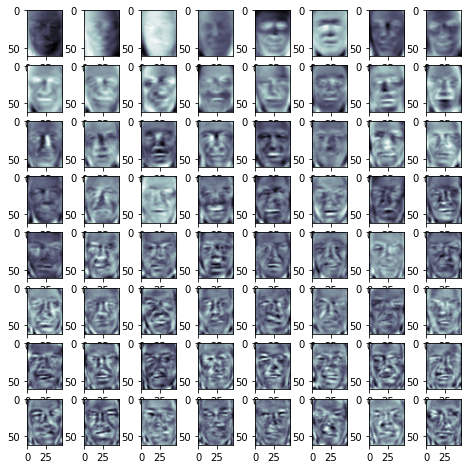

In [33]:
#Plot eigenfaces
fig=plt.figure(figsize=(8,8))
for i in range(64):
    ax=fig.add_subplot(8,8,i+1)
    plt.imshow(eigen_faces[i],cmap=plt.cm.bone)
plt.show()

In [34]:
#Renaming training data
x_train_pca=x_transformed
#Tranforming testing data
x_test_pca=pca_lwf.transform(x_test)
#stores scores of every algorithm
all_scores=[]

## Apply ML Algorithms

## Random Forest

In [35]:
# rf=ensemble.RandomForestClassifier(random_state=0)
# start=time.time()
# rf.fit(x_train,y_train)
# print("Time taken = ",time.time()-start)
# y_pred=rf.predict(x_test)
# print(classification_report(y_test,y_pred))
# print(confusion_matrix(y_test,y_pred))

In [36]:
# oversample = imblearn.over_sampling.RandomOverSampler(sampling_strategy="not majority")
# x_train,y_train=oversample.fit_resample(x_train,y_train)

In [37]:
#without PCA 
rf=ensemble.RandomForestClassifier(max_leaf_nodes=137,random_state=0)
start=time.time()
rf.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  0.19251155853271484
              precision    recall  f1-score   support

           0       0.79      0.85      0.82        61
           1       0.94      0.44      0.60        36
           2       0.74      0.98      0.84       122
           3       0.95      0.61      0.75        31
           4       0.86      0.51      0.64        35

    accuracy                           0.79       285
   macro avg       0.86      0.68      0.73       285
weighted avg       0.81      0.79      0.77       285

[[ 52   0   9   0   0]
 [  9  16  11   0   0]
 [  3   0 119   0   0]
 [  0   1   8  19   3]
 [  2   0  14   1  18]]


In [38]:
#with PCA
rf_pca=ensemble.RandomForestClassifier(max_leaf_nodes=137,random_state=0)
start=time.time()
rf_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=rf_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  0.44979286193847656
              precision    recall  f1-score   support

           0       0.80      0.79      0.79        61
           1       0.95      0.58      0.72        36
           2       0.70      0.97      0.81       122
           3       0.85      0.35      0.50        31
           4       0.86      0.51      0.64        35

    accuracy                           0.76       285
   macro avg       0.83      0.64      0.69       285
weighted avg       0.79      0.76      0.74       285

[[ 48   0  12   1   0]
 [  2  21  13   0   0]
 [  1   1 118   1   1]
 [  6   0  12  11   2]
 [  3   0  14   0  18]]


In [39]:
print(rf_pca.score(x_train_pca,y_train),rf_pca.score(x_test_pca,y_test))

non_pca_score=rf.score(x_test,y_test)
pca_score=rf_pca.score(x_test_pca,y_test)
all_scores.append(["Random Forest :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

1.0 0.7578947368421053
0.7859649122807018 0.7578947368421053


## SVC


In [40]:
#without PCA
svc=SVC()
start=time.time()
svc.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  1.7308552265167236
              precision    recall  f1-score   support

           0       0.88      0.93      0.90        61
           1       0.90      0.78      0.84        36
           2       0.89      0.96      0.92       122
           3       0.92      0.77      0.84        31
           4       0.90      0.80      0.85        35

    accuracy                           0.89       285
   macro avg       0.90      0.85      0.87       285
weighted avg       0.89      0.89      0.89       285

[[ 57   1   3   0   0]
 [  2  28   6   0   0]
 [  3   1 117   0   1]
 [  1   1   3  24   2]
 [  2   0   3   2  28]]


In [41]:
print(svc.score(x_train,y_train),svc.score(x_test,y_test))

0.9950980392156863 0.8912280701754386


In [42]:
#with PCA
svc_pca=SVC()
start=time.time()
svc_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=svc_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  0.09368395805358887
              precision    recall  f1-score   support

           0       0.92      0.95      0.94        61
           1       0.97      0.81      0.88        36
           2       0.88      0.98      0.93       122
           3       0.92      0.77      0.84        31
           4       0.97      0.83      0.89        35

    accuracy                           0.91       285
   macro avg       0.93      0.87      0.90       285
weighted avg       0.92      0.91      0.91       285

[[ 58   0   3   0   0]
 [  3  29   4   0   0]
 [  0   0 120   2   0]
 [  2   1   3  24   1]
 [  0   0   6   0  29]]


In [43]:
print(svc_pca.score(x_train_pca,y_train),svc_pca.score(x_test_pca,y_test))

non_pca_score=svc.score(x_test,y_test)
pca_score=svc_pca.score(x_test_pca,y_test)
all_scores.append(["Support Vector Classifier :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

0.9990196078431373 0.9122807017543859
0.8912280701754386 0.9122807017543859


## Logistic Regression

In [44]:
#without PCA
lr=LogisticRegression()
start=time.time()
lr.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  0.5900030136108398
              precision    recall  f1-score   support

           0       0.89      0.84      0.86        61
           1       0.76      0.81      0.78        36
           2       0.86      0.92      0.89       122
           3       0.89      0.77      0.83        31
           4       0.94      0.89      0.91        35

    accuracy                           0.87       285
   macro avg       0.87      0.84      0.86       285
weighted avg       0.87      0.87      0.87       285

[[ 51   3   4   1   2]
 [  1  29   6   0   0]
 [  3   5 112   2   0]
 [  2   1   4  24   0]
 [  0   0   4   0  31]]


c:\Users\Dell\anaconda3\lib\site-packages\daal4py\sklearn\linear_model\logistic_path.py:459: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [45]:
#with PCA
lr_pca=LogisticRegression()
start=time.time()
lr_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=lr_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

Time taken =  0.012955427169799805
              precision    recall  f1-score   support

           0       0.79      0.89      0.84        61
           1       0.86      0.69      0.77        36
           2       0.91      0.89      0.90       122
           3       0.79      0.71      0.75        31
           4       0.80      0.91      0.85        35

    accuracy                           0.85       285
   macro avg       0.83      0.82      0.82       285
weighted avg       0.85      0.85      0.85       285

[[ 54   2   3   1   1]
 [  5  25   4   0   2]
 [  6   0 109   4   3]
 [  3   2   2  22   2]
 [  0   0   2   1  32]]


In [46]:
print(lr_pca.score(x_train_pca,y_train),lr_pca.score(x_test_pca,y_test))

non_pca_score=lr.score(x_test,y_test)
pca_score=lr_pca.score(x_test_pca,y_test)
all_scores.append(["Logistic Regression :",non_pca_score,pca_score])
print(non_pca_score,pca_score)

0.9740196078431372 0.8491228070175438
0.8666666666666667 0.8491228070175438


## Naive Bayes

In [47]:
#without PCA
gnb=GaussianNB()
start=time.time()
gnb.fit(x_train,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb.predict(x_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


Time taken =  0.03546929359436035
              precision    recall  f1-score   support

           0       0.42      0.59      0.49        61
           1       0.55      0.61      0.58        36
           2       0.80      0.65      0.71       122
           3       0.48      0.35      0.41        31
           4       0.58      0.63      0.60        35

    accuracy                           0.60       285
   macro avg       0.57      0.57      0.56       285
weighted avg       0.62      0.60      0.60       285

[[36  9  9  2  5]
 [11 22  2  1  0]
 [24  7 79  7  5]
 [ 7  2  5 11  6]
 [ 7  0  4  2 22]]


In [48]:
#with PCA
gnb_pca=GaussianNB()
start=time.time()
gnb_pca.fit(x_train_pca,y_train)
print("Time taken = ",time.time()-start)
y_pred=gnb_pca.predict(x_test_pca)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))


Time taken =  0.0019941329956054688
              precision    recall  f1-score   support

           0       0.88      0.82      0.85        61
           1       0.72      0.72      0.72        36
           2       0.86      0.89      0.87       122
           3       0.69      0.71      0.70        31
           4       0.66      0.66      0.66        35

    accuracy                           0.80       285
   macro avg       0.76      0.76      0.76       285
weighted avg       0.80      0.80      0.80       285

[[ 50   2   4   0   5]
 [  2  26   3   4   1]
 [  3   4 108   3   4]
 [  0   3   4  22   2]
 [  2   1   6   3  23]]


In [49]:
print(gnb_pca.score(x_train_pca,y_train),gnb_pca.score(x_test_pca,y_test))

non_pca_score=gnb.score(x_test,y_test)
pca_score=gnb_pca.score(x_test_pca,y_test)
all_scores.append(["Gaussian Naive Bayes :",non_pca_score,pca_score])

0.888235294117647 0.8035087719298246


### Tabulate scores of all the algorithms

In [53]:
print(pd.DataFrame(all_scores,columns={"Algorithms","Without PCA","With PCA"} ))

                    Algorithms  With PCA  Without PCA
0              Random Forest :  0.785965     0.757895
1  Support Vector Classifier :  0.891228     0.912281
2        Logistic Regression :  0.866667     0.849123
3       Gaussian Naive Bayes :  0.596491     0.803509
